In [1]:
%matplotlib inline
import cPickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

In [2]:
def plot_confusion_matrix(y_test,y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def image_rotation(x, rg,step, row_index=0, col_index=1, channel_index=2,
                    fill_mode='nearest', cval=0.):
    image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
    for i in range(-rg,rg,step):
        theta = (np.pi  * i)/ 180
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

        h, w = x.shape[row_index], x.shape[col_index]
        transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
        new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
        image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set

def image_shear(x,  row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    shear = [-0.25,0.25,6.3,9.5,-9.5,2.95,-2.95,0]
    image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
    for i in shear:
        shear_matrix = np.array([[1, -np.sin(i), 0],
                             [0, np.cos(i), 0],
                             [0, 0, 1]])
        h, w = x.shape[row_index], x.shape[col_index]
        transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
        new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
        image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set[1:]



def image_zoom(x, zoom_range,step, row_index=0, col_index=1, channel_index=2,
                fill_mode='nearest', cval=0.):
    if len(zoom_range) != 2:
        raise Exception('zoom_range should be a tuple or list of two floats. '
                        'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
        for zx in np.arange(zoom_range[0],zoom_range[1],step):
            for zy in np.arange(zoom_range[0],zoom_range[1],step):
                zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

                h, w = x.shape[row_index], x.shape[col_index]
                transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
                new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
                image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set[1:]

def image_shift(x, wrg, hrg,step ,row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    h,w = x.shape[row_index],x.shape[col_index]
    image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
    for tx in np.arange(-hrg*h,hrg*h,step):
        for ty in np.arange(-wrg*h,wrg*h,step):
            translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

            transform_matrix = translation_matrix  # no need to do offset
            new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
            image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set[1:]

In [4]:
def load_data():
    import pandas as pd
    import numpy as np
    from PIL import Image
    from cv2 import resize
    
    train = pd.read_csv('/home/mckc/cleaned///train.csv')
    test = pd.read_csv('/home/mckc/cleaned///test.csv')
    
    #train = train.query('subject in ("Dhruva Murari","Ponraj S","Naresh Raj","Raashi Chhalani","naveen","Praba")')
    #test = test.query('subject in ("Dhruva Murari","Ponraj S","Naresh Raj","Raashi Chhalani","naveen","Praba")')
    print 'the training data shape is ',train.shape
    print 'the test data shape is ', test.shape
    
    X_tr = []
    Y_tr = []
    iteration = 0
    for i in train.values[:,0]:
        image = resize(np.array(Image.open(i).convert('L')),(96,96))
        #print image.shape
        X_tr.append(image)
        Y_tr.append(train.values[iteration,1])
        iteration+=1
        if iteration % 500==0:
            print colored((float(iteration)/len(train.values[:,0])*100 ,' Percentage complete'), 'green')
            
            
    X_ts = []
    Y_ts = []
    iteration = 0
    for i in test.values[:,0]:
        image = resize(np.array(Image.open(i).convert('L')),(96,96))
        X_ts.append(image)
        Y_ts.append(test.values[iteration,1])
        iteration+=1
        if iteration % 500==0:
            print colored((float(iteration)/len(test.values[:,0])*100 ,' Percentage complete'), 'green')
    X_tr,X_ts,Y_tr,Y_ts = np.array(X_tr),np.array(X_ts),np.array(Y_tr),np.array(Y_ts)
    print 'the training file shape',X_tr.shape,Y_tr.shape
    print 'the testing file shape',X_ts.shape,Y_ts.shape
    
    return X_tr,X_ts,Y_tr,Y_ts   

In [5]:
def simulate(X,Y):
    import scipy as sp
    import scipy.ndimage
    complete = np.zeros((1,96,96),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        #complete = np.vstack((complete,X[i,:,:].reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -10,reshape=False,cval=255).reshape(1,96,96)))
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -15,reshape=False,cval=255).reshape(1,96,96)))
        #complete = np.vstack((complete,rotated.reshape(1,96,96)))
        Y_complete = np.append(Y_complete,([Y[i]]*12))
        if i % 50==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [6]:
def augment(X,Y):
    import skimage.transform as tf
    import scipy as sp
    import scipy.ndimage
    complete = np.zeros((1,96,96),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        #complete = np.vstack((complete,X[i,:,:].reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(0,-5))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(0,5))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(5,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(-5,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(0,-5))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(0,5))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(5,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(-5,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(0,-5))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(0,5))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(5,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(-5,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        
        tform = tf.SimilarityTransform(scale=1,translation=(0,-3))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(0,3))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(3,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1,translation=(-3,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(0,-3))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(0,3))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(3,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=1.2,translation=(-3,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(0,-3))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(0,3))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(3,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.SimilarityTransform(scale=0.8,translation=(-3,0))
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))

        
        tform = tf.AffineTransform(scale=(1,1),shear=0.25)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=0.2)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=0.15)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=0.1)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=-0.25)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=-0.2)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=-0.15)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        tform = tf.AffineTransform(scale=(1,1),shear=-0.1)
        complete = np.vstack((complete,tf.warp(X[i,:,:], tform).reshape(1,96,96)))
        
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -15,reshape=False,cval=255).reshape(1,96,96)))
        
        
        Y_complete = np.append(Y_complete,([Y[i]]*44))
        if i % 50==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [7]:
def Save_data(X,Y,data):
    for i in range(len(X)):
        file_name = '/home/mckc/face_'+data+'/'+Y[i]+'_'+str(i)+'.npy'
        np.save(file_name,X[i,:,:])

In [8]:
def load(data):
    import os
    import numpy as np
    files = os.listdir('/home/mckc/face_'+data+'/')    
    X = np.zeros((1,96,96),dtype=np.float64)
    Y = []
    iter = 0
    for i in files:
        X = np.vstack((X,np.load('/home/mckc/face_'+data+'/'+i).reshape(1,96,96)))
        index = i.index('_')
        Y = np.append(Y,i[:index])
        iter = iter+1
        if iter % 800 ==0:
            print colored((float(iter)/len(files)*100 ,' Percentage complete'), 'green')
            
    print X[1:,:,:].shape,Y.shape
    return X[1:,:,:],Y

In [9]:
#from cv2 import resize
from skimage import exposure
import os
import cv2
import numpy as np

images_geq = []
images = []
label=[]
files = os.listdir('/home/mckc/aug/face_labels/All')
for i in files:
    image =cv2.resize(cv2.imread('/home/mckc/aug/face_labels/All/'+i,0),(96,96))
    image_geq = exposure.equalize_hist(image)

    # Equalization
    images.append(image)
    images_geq.append(image_geq)
    label.append(i)
image_data = np.array(images).reshape(-1,9216)
images_geq = np.array(images_geq).reshape(-1,9216)

In [10]:
X_train,X_ts,Y_train,Y_ts    = load_data()
#X_tr,X_ts,Y_tr,Y_ts    = load_data()

the training data shape is  (505, 2)
the test data shape is  (169, 2)
(99.00990099009901, ' Percentage complete')
the training file shape (505, 96, 96) (505,)
the testing file shape (169, 96, 96) (169,)


In [13]:
#X_tr,Y_tr = simulate(X_train,Y_train)
X_tr,Y_tr = augment(X_train,Y_train)
print X_tr.shape,Y_tr.shape

(0.0, ' Percentage complete')
(9.900990099009901, ' Percentage complete')
(19.801980198019802, ' Percentage complete')
(29.7029702970297, ' Percentage complete')
(39.603960396039604, ' Percentage complete')
(49.504950495049506, ' Percentage complete')
(59.4059405940594, ' Percentage complete')
(69.3069306930693, ' Percentage complete')
(79.20792079207921, ' Percentage complete')
(89.10891089108911, ' Percentage complete')
(99.00990099009901, ' Percentage complete')
(22220, 96, 96) (22220,)


In [14]:
Save_data(X_tr,Y_tr,'train')
Save_data(X_ts,Y_ts,'test')

In [15]:
start_time = time.time()
X_tr,Y_tr = load('train')
X_ts,Y_ts = load('test')
print(time.time()-start_time)

(2.2398924851607123, ' Percentage complete')
(4.4797849703214245, ' Percentage complete')
(6.719677455482137, ' Percentage complete')
(8.959569940642849, ' Percentage complete')
(11.19946242580356, ' Percentage complete')
(13.439354910964274, ' Percentage complete')
(15.679247396124987, ' Percentage complete')
(17.919139881285698, ' Percentage complete')
(20.15903236644641, ' Percentage complete')
(22.39892485160712, ' Percentage complete')
(24.638817336767836, ' Percentage complete')
(26.87870982192855, ' Percentage complete')
(29.118602307089258, ' Percentage complete')
(31.358494792249974, ' Percentage complete')
(33.59838727741069, ' Percentage complete')
(35.838279762571396, ' Percentage complete')
(38.07817224773211, ' Percentage complete')
(40.31806473289282, ' Percentage complete')
(42.55795721805353, ' Percentage complete')
(44.79784970321424, ' Percentage complete')
(47.037742188374956, ' Percentage complete')
(49.27763467353567, ' Percentage complete')
(51.51752715869639, ' 

In [12]:
from sklearn.utils import shuffle
X_tr,Y_tr = shuffle(X_tr,Y_tr)
X_normal = X_tr.reshape(-1,9216)
X_test_normal = X_ts.reshape(-1,9216)
map, Y_number = np.unique(Y_tr, return_inverse=True)
Y_test_number = np.unique(Y_ts, return_inverse=True)[1]
np.save('/home/mckc/map',map)

NameError: name 'X_tr' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

In [ ]:
map = np.load('/home/mckc/map.npy')
loaded_model = pickle.load(open('/home/mckc/Face_code/logistic.pkl', 'rb'))
Y_prob = clf.predict_proba(image_geq.reshape(-1,9216))
a= np.array([map[i] for i in np.argsort(Y_prob,axis=1)],dtype=np.chararray)[:,:4]
zip(label==a[:,0])

Accuracy of the model is  0.775147928994
Normalized confusion matrix


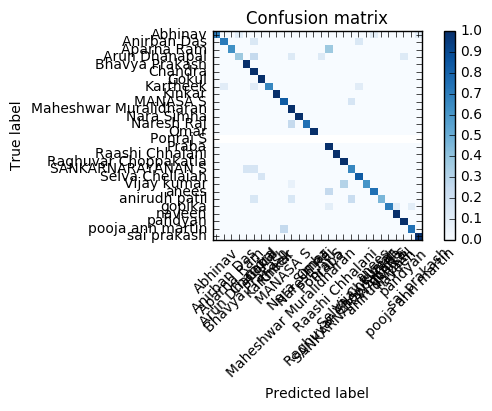

In [58]:
clf = LogisticRegression(verbose=0,n_jobs=-1,multi_class='multinomial',solver='lbfgs',max_iter=50,warm_start=True)
clf.fit(X_normal,Y_number)
Y_logictic= clf.predict(X_ts.reshape(-1,9216))
#confusion_matrix(map[Y_logictic],Y_ts,labels=map)
print 'Accuracy of the model is ',accuracy_score(map[Y_logictic],Y_ts)
plot_confusion_matrix(map[Y_logictic],Y_ts, classes=map,normalize=True,title='Confusion matrix')

In [59]:
pickle.dump(clf, open('/home/mckc/Face_code/logistic.pkl', 'wb'))

Abhinav


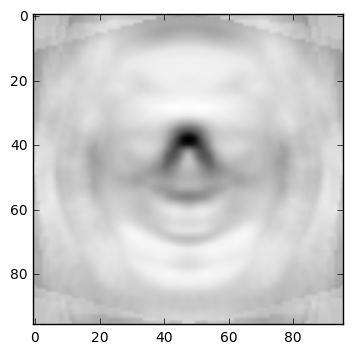

In [60]:
print map[0]
plt.imshow(clf.coef_[0,:].reshape(96,96),cmap=cm.Greys_r)

Anirban Das


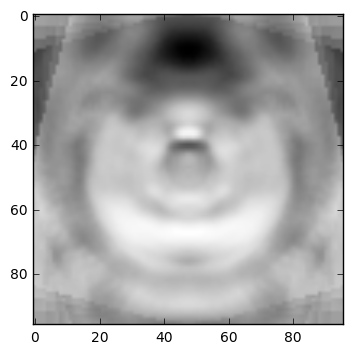

In [61]:
print map[1]
plt.imshow(clf.coef_[1,:].reshape(96,96),cmap=cm.Greys_r)

Aparna Ram


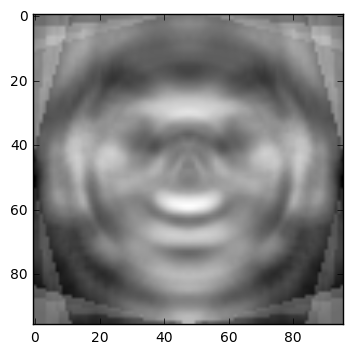

In [62]:
print map[2]
plt.imshow(clf.coef_[2,:].reshape(96,96),cmap=cm.Greys_r)

Arun Dhanapal


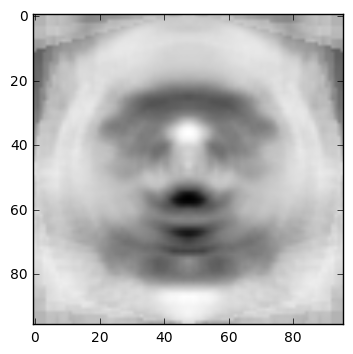

In [63]:
print map[3]
plt.imshow(clf.coef_[3,:].reshape(96,96),cmap=cm.Greys_r)

Bhavya Prakash


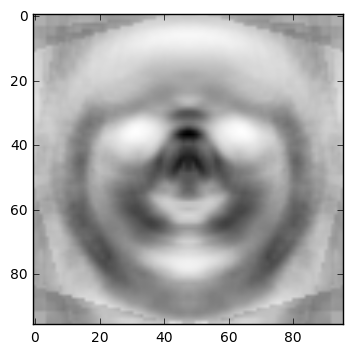

In [64]:
print map[4]
plt.imshow(clf.coef_[4,:].reshape(96,96),cmap=cm.Greys_r)

Chandra


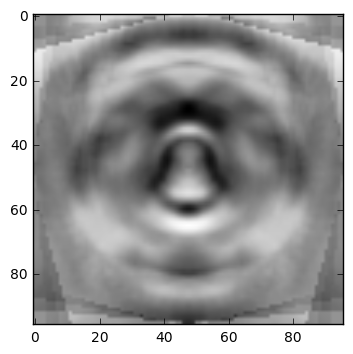

In [65]:
print map[5]
plt.imshow(clf.coef_[5,:].reshape(96,96),cmap=cm.Greys_r)

Gokul


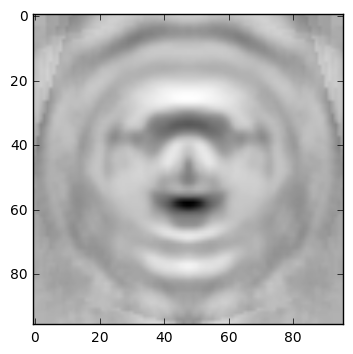

In [66]:
print map[6]
plt.imshow(clf.coef_[6,:].reshape(96,96),cmap=cm.Greys_r)

Kartheek


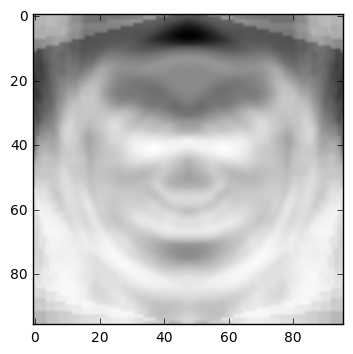

In [67]:
print map[7]
plt.imshow(clf.coef_[7,:].reshape(96,96),cmap=cm.Greys_r)

Kinkar


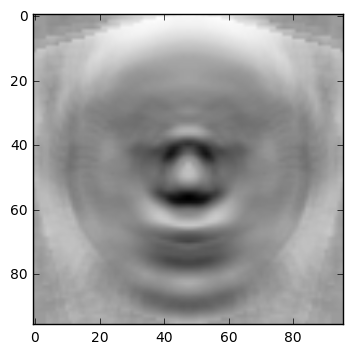

In [68]:
print map[8]
plt.imshow(clf.coef_[8,:].reshape(96,96),cmap=cm.Greys_r)

MANASA S


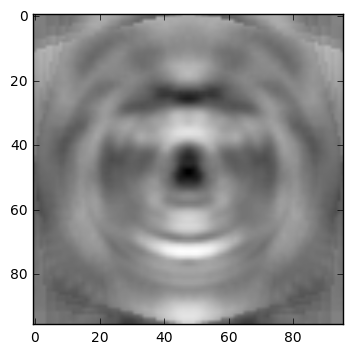

In [69]:
print map[9]
plt.imshow(clf.coef_[9,:].reshape(96,96),cmap=cm.Greys_r)

Maheshwar Muralidharan


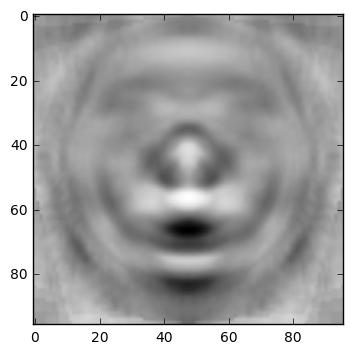

In [70]:
print map[10]
plt.imshow(clf.coef_[10,:].reshape(96,96),cmap=cm.Greys_r)

Nara Simha


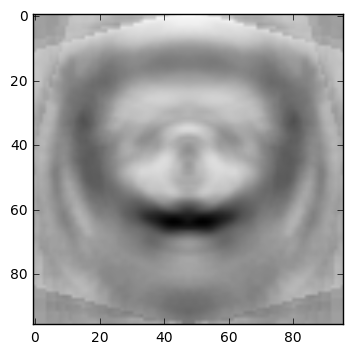

In [71]:
print map[11]
plt.imshow(clf.coef_[11,:].reshape(96,96),cmap=cm.Greys_r)

Naresh Raj


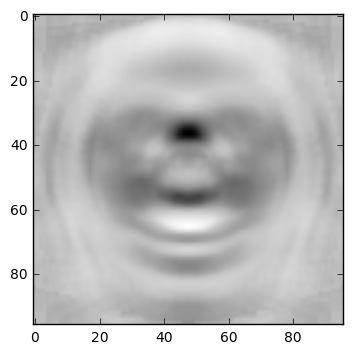

In [72]:
print map[12]
plt.imshow(clf.coef_[12,:].reshape(96,96),cmap=cm.Greys_r)

Omar


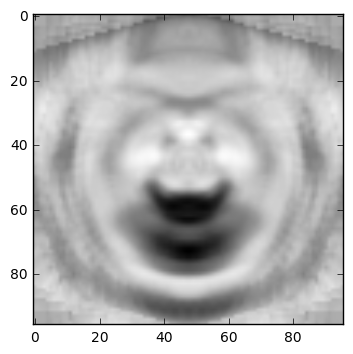

In [73]:
print map[13]
plt.imshow(clf.coef_[13,:].reshape(96,96),cmap=cm.Greys_r)

Ponraj S


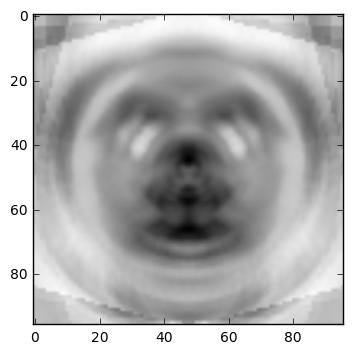

In [74]:
print map[14]
plt.imshow(clf.coef_[14,:].reshape(96,96),cmap=cm.Greys_r)

Praba


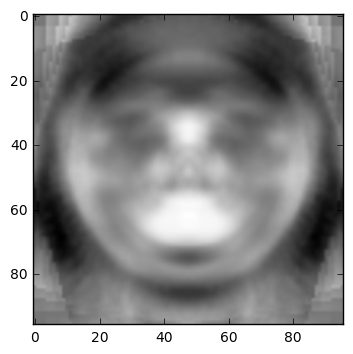

In [75]:
print map[15]
plt.imshow(clf.coef_[15,:].reshape(96,96),cmap=cm.Greys_r)

Raashi Chhalani


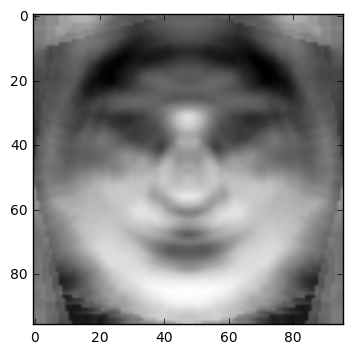

In [76]:
print map[16]
plt.imshow(clf.coef_[16,:].reshape(96,96),cmap=cm.Greys_r)

Raghuvar Choppakatla


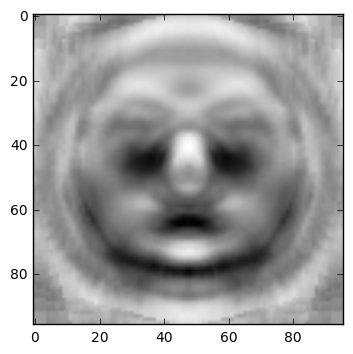

In [77]:
print map[17]
plt.imshow(clf.coef_[17,:].reshape(96,96),cmap=cm.Greys_r)

SANKARNARAYANAN S


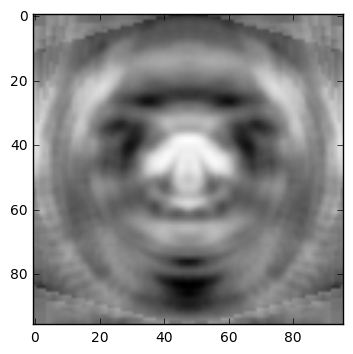

In [78]:
print map[18]
plt.imshow(clf.coef_[18,:].reshape(96,96),cmap=cm.Greys_r)

Selva Chellaiah


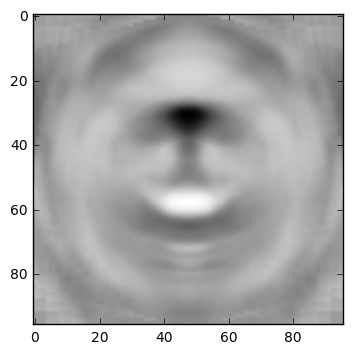

In [79]:
print map[19]
plt.imshow(clf.coef_[19,:].reshape(96,96),cmap=cm.Greys_r)

Vijay kumar


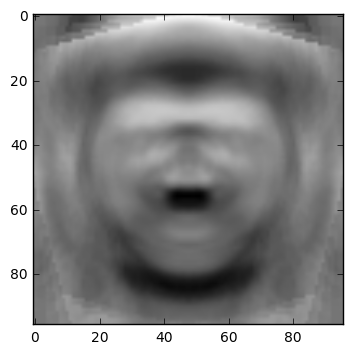

In [80]:
print map[20]
plt.imshow(clf.coef_[20,:].reshape(96,96),cmap=cm.Greys_r)

anees


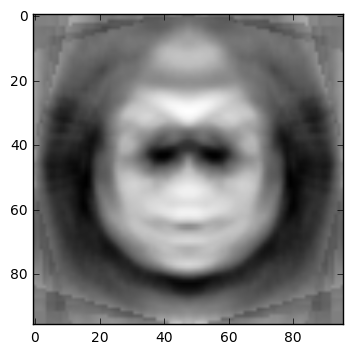

In [81]:
print map[21]
plt.imshow(clf.coef_[21,:].reshape(96,96),cmap=cm.Greys_r)

anirudh patil


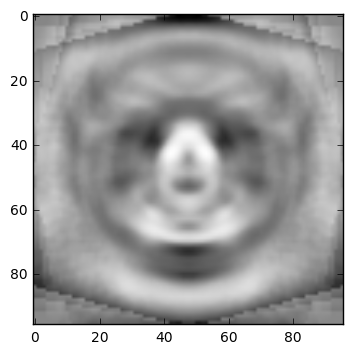

In [82]:
print map[22]
plt.imshow(clf.coef_[22,:].reshape(96,96),cmap=cm.Greys_r)

gopika


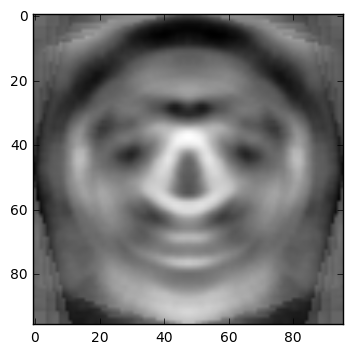

In [83]:
print map[23]
plt.imshow(clf.coef_[23,:].reshape(96,96),cmap=cm.Greys_r)

naveen


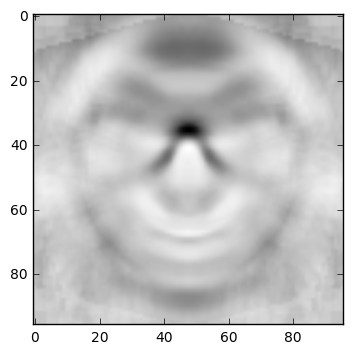

In [84]:
print map[24]
plt.imshow(clf.coef_[24,:].reshape(96,96),cmap=cm.Greys_r)

pandyan


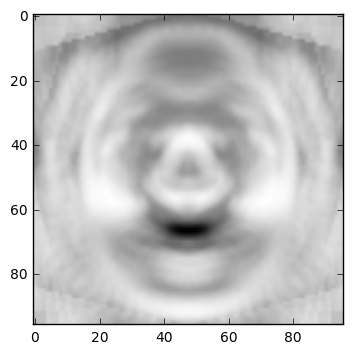

In [85]:
print map[25]
plt.imshow(clf.coef_[25,:].reshape(96,96),cmap=cm.Greys_r)

pooja ann martin


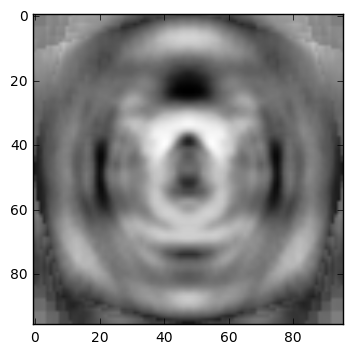

In [86]:
print map[26]
plt.imshow(clf.coef_[26,:].reshape(96,96),cmap=cm.Greys_r)

sai prakash


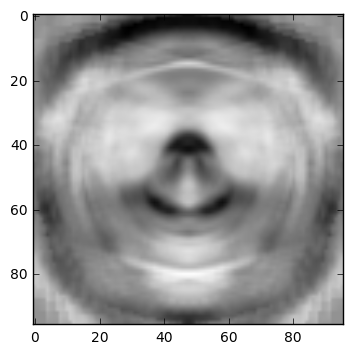

In [87]:
print map[27]
plt.imshow(clf.coef_[27,:].reshape(96,96),cmap=cm.Greys_r)

Accuracy of the model is  0.91124260355
Normalized confusion matrix


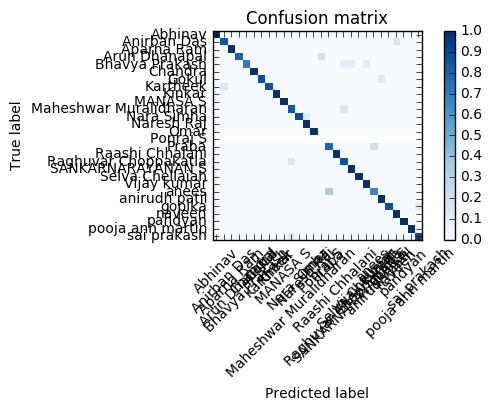

In [88]:
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=-1,warm_start=True)
recognizer.fit(X_normal,Y_number)

Y_rf= recognizer.predict(X_ts.reshape(-1,9216))
Y_rf_vales = map[Y_rf]

print 'Accuracy of the model is ',accuracy_score(Y_ts,Y_rf_vales)
plt.figure(10)
plot_confusion_matrix(Y_rf_vales,Y_ts, classes=map,normalize=True,title='Confusion matrix')

In [90]:
pickle.dump(recognizerzer, open('/home/mckc/Face_code/rf.pkl', 'wb'))

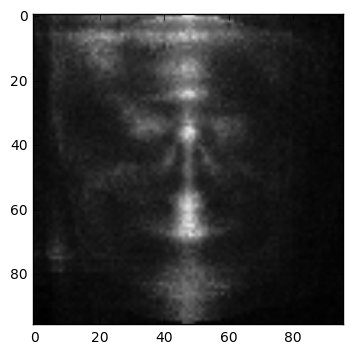

In [89]:
importances = recognizer.feature_importances_
importance_image = importances.reshape(96,96)
#plt.figure(figsize=(7,7))
plt.imshow(importance_image,cmap=cm.Greys_r)

Accuracy of the model is  0.85798816568
Normalized confusion matrix


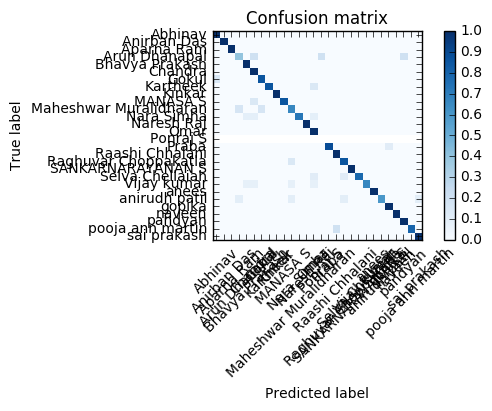

In [72]:
#Fishers
recognizer = cv2.createLBPHFaceRecognizer()
recognizer.train(X_tr, Y_number)

Y_LBP = [recognizer.predict(X_ts[i])[0] for i in range(X_ts.shape[0])]
print 'Accuracy of the model is ',accuracy_score(map[Y_LBP],Y_ts)
plot_confusion_matrix(map[Y_LBP],Y_ts, classes=map,normalize=True,title='Confusion matrix')

Accuracy of the model is  0.781065088757
Normalized confusion matrix


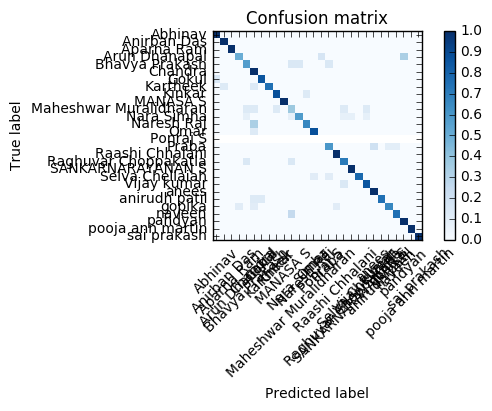

In [ ]:
#Fishers
recognizer = cv2.createEigenFaceRecognizer()
recognizer.train(X_tr, Y_number)

Y_LBP = [recognizer.predict(X_ts[i])[0] for i in range(X_ts.shape[0])]
print 'Accuracy of the model is ',accuracy_score(map[Y_LBP],Y_ts)
plot_confusion_matrix(map[Y_LBP],Y_ts, classes=map,normalize=True,title='Confusion matrix')

In [ ]:
#Fishers
recognizer = cv2.createFisherFaceRecognizer()
recognizer.train(X_tr, Y_number)

Y_LBP = [recognizer.predict(X_ts[i])[0] for i in range(X_ts.shape[0])]
print 'Accuracy of the model is ',accuracy_score(map[Y_LBP],Y_ts)
plot_confusion_matrix(map[Y_LBP],Y_ts, classes=map,normalize=True,title='Confusion matrix')

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD,Adagrad,Adadelta
from keras.utils import np_utils
#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=2)


Y_Keras = np_utils.to_categorical(Y_number, 28)
Y_test_keras = np_utils.to_categorical(Y_test_number, 28)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=9216,activation='sigmoid'))
#model.add(Dense(500,activation='sigmoid'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(28,activation='softmax'))
adagrad = Adagrad(lr=0.0001, epsilon=1e-08)
adadelta = Adadelta(lr=.1, rho=0.95, epsilon=1e-08)
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Using Theano backend.
Using gpu device 0: Quadro M2000M (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)


In [84]:
model.fit(X_tr.reshape(-1,9216), Y_Keras, nb_epoch=300, batch_size=10,verbose=1
         ,validation_data=(X_ts.reshape(-1,9216),Y_test_keras ))

Y_kr= model.predict_classes(X_ts.reshape(-1,9216))

print 'Accuracy of the model is ',accuracy_score(Y_ts,map[Y_kr],'\n')
#confusion_matrix(Y_ts,Y_kr_vales)
plot_confusion_matrix(map[Y_kr],Y_ts, classes=map,normalize=True,title='Confusion matrix')

Train on 14140 samples, validate on 169 samples
Epoch 1/300
14140/14140 [==============================] - 14s - loss: 3.0642 - acc: 0.1653 - val_loss: 2.6604 - val_acc: 0.3136
Epoch 2/300
14140/14140 [==============================] - 14s - loss: 2.7141 - acc: 0.2875 - val_loss: 2.2335 - val_acc: 0.4201
Epoch 3/300
14140/14140 [==============================] - 14s - loss: 2.4625 - acc: 0.3412 - val_loss: 1.9744 - val_acc: 0.5266
Epoch 4/300
14140/14140 [==============================] - 14s - loss: 2.2817 - acc: 0.3818 - val_loss: 1.7919 - val_acc: 0.5266
Epoch 5/300
14140/14140 [==============================] - 14s - loss: 2.1317 - acc: 0.4151 - val_loss: 1.6299 - val_acc: 0.5385
Epoch 6/300
14140/14140 [==============================] - 14s - loss: 2.0029 - acc: 0.4533 - val_loss: 1.4859 - val_acc: 0.6213
Epoch 7/300
14140/14140 [==============================] - 14s - loss: 1.8961 - acc: 0.4784 - val_loss: 1.4306 - val_acc: 0.6095
Epoch 8/300
14140/14140 [========================

KeyboardInterrupt: 

In [98]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,AveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam,SGD,Adadelta,Adagrad
from keras import backend as K

Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)

model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',input_shape=( 1, 96, 96),activation='relu'))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
#model.add(Convolution2D(96, 3, 3,border_mode='same',activation='relu'))
#model.add(Convolution2D(192, 3, 3,border_mode='same',activation='relu'))
#model.add(MaxPooling2D((2,2), strides=(2,2)))
#model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
#model.add(Convolution2D(256, 3, 3,border_mode='same',activation='relu'))
#model.add(MaxPooling2D((2,2), strides=(2,2)))
#model.add(Convolution2D(160, 3, 3,border_mode='same',activation='relu'))
#model.add(Convolution2D(320, 3, 3,border_mode='same',activation='relu'))
#model.add(AveragePooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Flatten())
model.add(Dense(1000,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1000,activation='relu'))
model.add(Dense(28,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
#model.load_weights("model.h5")

Using Theano backend.


AttributeError: 'module' object has no attribute 'tests'

In [ ]:
model.fit(X_tr.reshape(-1,96,96), Y_Keras, nb_epoch=30, batch_size=10,verbose=1
         ,validation_data=(X_ts.reshape(-1,96,96),Y_test_keras ))

Y_kr= model.predict_classes(X_ts.reshape(-1,96,96))

print 'Accuracy of the model is ',accuracy_score(Y_ts,Y_kr_vales,'\n')
#confusion_matrix(Y_ts,Y_kr_vales)
plot_confusion_matrix(map[Y_kr],Y_ts, classes=map,normalize=True,title='Confusion matrix')